ID: 20210731

Name: Nguyen Thi Linh

# **Final project: Fraud detection in custom declaration**


## **Project outline:**




1.   Motivation
2.   Data Schema
3. Preparing Data
4. Reducing dimension
5. Machine learning models <br>
a. KNeighborsClassifier <br>
b. Neural Network <br>
6. Result compare and conclusion



## **1. Motivation:**
Currently, international trade is growing, leading to an increase in the volume of goods flowing across national borders. Effectively controlling transactions is crucial to protect people and national economies, prevent illegal transactions, and facilitate legitimate trade.

When goods are imported into a country, they need to be declared, and customs officials will inspect whether the goods are legal. In the case of imported goods, if the value of the shipment exceeds a certain threshold, customs will impose tariffs on the items. Once the tariff is paid, the goods are allowed to be released.

This manual inspection process can be time-consuming and requires a large workforce when dealing with a high volume of goods. Based on the work of a customs officer, they collect information from the declaration form and use their trained knowledge to determine whether the goods are fraudulent or not. This is similar to a machine learning model, where the model is trained on past information and makes predictions based on that.

Therefore, in this project, I will build a machine learning model for fraud detection based on the available customs information.

## **2. Data Schema**
<br>Because immigration-related information is important to the country, obtaining raw information from the customs department is challenging. Professor Chaeyoon Jeong from KAIST, Sundong Kim from IBS, and Jaewoo Park, Yeonsoo Choi from Korea Customs Service have collaborated to generate a synthetic data set from the original data to serve various research purposes. In the synthetic data set, personal information has been randomly generated.
<br>
Among 24.7 million customs declarations reported for 18 months between January 1, 2020 and June 30, 2021, they used the inspected (i.e., labeled) part of the declarations to synthesize this dataset. Each row describes the report of a single goods. Among 62 attributes in the import declaration form, the data includes 22 representative attributes including two labels, fraud and critical fraud. Detailed data descriptions are as follows[1].

![Import Declaration](https://github.com/Seondong/Customs-Declaration-Datasets/blob/a33cfc36546d9951fb469951816bb6771cec208c/resources/import_declaration_form.JPG?raw=true)




| Attribute               | Description                                              |
| ------------------ | ------------------------------------------------- |
| Declaration ID           | Primary key of the record                           |
| Date           | Date when the declaration is reported                           |
| Office ID       | Customs office that receives the declaration (e.g., Seoul regional customs)                               |
| Process type | Type of the declaration process (e.g., Paperless declaration) |
| Import type | Code for import type (e.g., OEM import, E-commerce)                         |
| Import use | Code for import use (e.g., Raw materials for domestic consumption)     |
| Payment type | Distinguish tariff payment type (e.g., Usance credit payable at sight)                        |
| Mode of transport | Nine modes of transport (e.g., maritime, rail, air)              |
| Declarant ID | Person who declares the item                  |
| Importer ID | Consumer who imports the item                             |
| Seller ID | Overseas business partner which supplies goods to Korea                           |
| Courier ID | Delivery service provider (e.g., DHL, FedEx)                     |
| HS6 code | 6-digit product code (e.g., 090121 = Coffee, Roasted, Not Decaffeinated)                             |
| Country of departure | Country from which a shipment has or is scheduled to depart             |
| Country of origin | Country of manufacture, production or design, or where an article or product comes from                            |
| Tax rate | Tax rate of the item (%)                              |
| Tax type | Tax types (e.g., FTA Preferential rate)               |
| Country of origin indicator | Way of indicating the country of origin (e.g., Mark on package)      |
| Net mass | Mass without any packaging (kg)                  |
| Item price | Assessed value of an item (KRW)                   |
| Fraud | Fraudulent attempt to reduce the customs duty (0/1), 0=non-fraud, 1=fraud                                    |
| Crifical fraud | Critical case which may threaten the public safety (0/1/2), 0=non-fraud, 1=fraud, 2=critical fraud               |

However, in this project, I will drop critical fraud olumn and focus solely on detecting fraud, or in other words, my objective is fraud detection.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from typing import List
import math
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist
from keras.models import Sequential
from keras.layers import Dense
train_df = pd.read_csv('https://raw.githubusercontent.com/Seondong/Customs-Declaration-Datasets/en/data/df_syn_train_eng.csv', index_col=0)
valid_df = pd.read_csv('https://raw.githubusercontent.com/Seondong/Customs-Declaration-Datasets/en/data/df_syn_valid_eng.csv', index_col=0)
test_df = pd.read_csv('https://raw.githubusercontent.com/Seondong/Customs-Declaration-Datasets/en/data/df_syn_test_eng.csv', index_col=0)

In [ ]:
train_df = train_df.drop('Critical Fraud', axis = 1)
valid_df = valid_df.drop('Critical Fraud', axis = 1)
test_df = test_df.drop('Critical Fraud', axis = 1)
print("Length of train dataset: " + str(len(train_df)))
print("Length of train dataset: " + str(len(valid_df)))
print("Length of train dataset: " + str(len(test_df)))
train_df.info()

Length of train dataset: 37385
Length of train dataset: 8134
Length of train dataset: 8481
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37385 entries, 97061800 to 46196555
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         37385 non-null  object 
 1   Office ID                    37385 non-null  int64  
 2   Process Type                 37385 non-null  object 
 3   Import Type                  37385 non-null  int64  
 4   Import Use                   37385 non-null  int64  
 5   Payment Type                 37385 non-null  int64  
 6   Mode of Transport            37385 non-null  int64  
 7   Declarant ID                 37385 non-null  object 
 8   Importer ID                  37385 non-null  object 
 9   Seller ID                    33670 non-null  object 
 10  Courier ID                   6714 non-null   object 
 11  HS6 Code                     37

## **3. Prepare Data**
Turn data into number, fill nan value with 0 and scale numeric columns.
There're 3 types of data: continuous numeric data, categorical data with numeric category and categorical data with category in string. Firstly, dataframe has many null value, filling null value with 0 is needed. Secondly, with continuous numeric data we need to scale using MinMaxScaler() to get data value between 0 and 1. Thirdly, with categorical data with category in string, we need to convert string category to numeric category by using factorize() function.

In [ ]:
def convert_data(x):
  #fill nan with
  x.fillna(0, inplace= True)
  #convert date to month
  if 'Date' in x.columns:
    new_month= pd.to_datetime(x['Date']).dt.month;
    month_update= pd.Series(new_month, name='Date');
    x.update(month_update);

  #split columns into 3 types: continuous numeric columns, categorical columns with numeric category and categorical columns with category in string
  numeric= ['Item Price', 'Net Mass', 'Tax Rate']
  numeric_category= ['Office ID', 'Import Type', 'Import Use', 'Payment Type', 'Mode of Transport', 'HS6 Code']
  category= ['Process Type','Declarant ID', 'Importer ID', 'Seller ID', 'Courier ID', 'Country of Departure', 'Country of Origin', 'Tax Type','Country of Origin Indicator']

  #Convert string category into numberic category
  for col in category:
    if col in x.columns:
      code_col, u_col= pd.factorize(x[col], sort= True)
      x[col] = code_col

  #scale numeric values
  scaler = MinMaxScaler()
  for col in numeric:
    if col in x.columns:
      scaler.fit(x[[col]])
      scaled_col= scaler.transform(x[[col]])
      x.update(pd.DataFrame(scaled_col, columns= [col]))
  return x

#get training attributes and labels
x_train = train_df.drop(['Fraud'], axis= 1)
x_valid = valid_df.drop(['Fraud'], axis= 1)
x_test = test_df.drop(['Fraud'], axis= 1)
X = pd.concat([x_train, x_valid, x_test], ignore_index= True);

y_train = train_df['Fraud']
y_valid = valid_df['Fraud']
y_test = test_df['Fraud']

x_cleaned = convert_data(X)
x_cleaned = x_cleaned.astype(np.float64)

#split converted data
x_train = x_cleaned.iloc[:len(y_train),:];
x_valid = x_cleaned.iloc[len(y_train): (len(y_train) + len(y_valid)),:];
x_test = x_cleaned.iloc[(len(y_train) + len(y_valid)) : ,:];
#free memory space
del x_cleaned

## **4. Reducing dimension**

Firstly, we will examine the correlation between features using a heatmap.


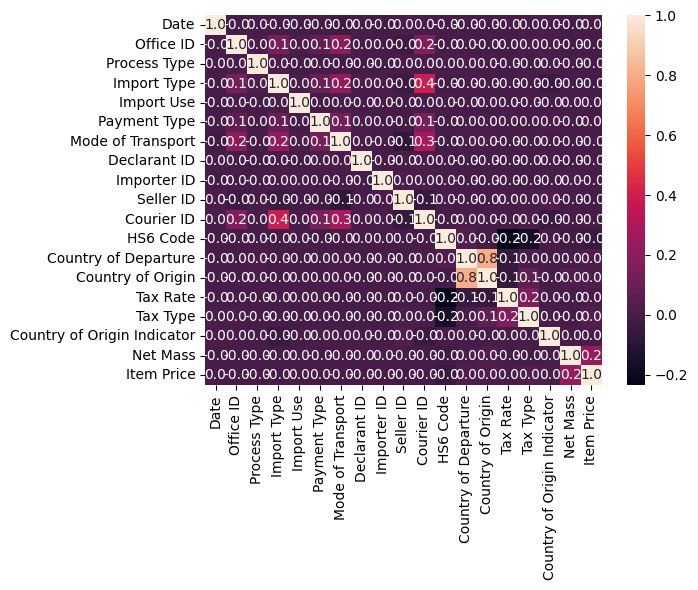

In [ ]:
import seaborn as sns

#plot heat map to see to correlation between attributes
ax= sns.heatmap(x_train.corr(), annot=True, fmt=".1f")

Except Country of Departure and Country of Origin have high correlation, all attribute seems to have no significant correlation. So I decided to keep dataset as the same.

In the Machine Learning course, we have learned about PCA. A brief overview of PCA is as follows:

PCA is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional space. It identifies the principal components in the data that explain the maximum variance. During feature selection, PCA does not consider the target class labels but focuses on maximizing variance. However, when dealing with categorical data with a small number of unique categories, PCA may not be very effective in reducing dimensionality.

In the dataset I am using, there are many categorical features. Therefore, using PCA may result in a loss of important information. Hence, it is necessary to explore alternative dimension reduction models.

So, why choose the Random Forest Classifier?

Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. It can perform implicit feature selection by evaluating the importance of each feature during the tree-building process. Random Forest considers the target class labels and their relationship with the input features. It can handle both numerical and categorical features, and is robust to outliers and missing values.

Random Forest provides a measure of feature importance based on the average reduction in impurity caused by each feature across all trees.

For example, consider the dataset in the figure[3]:

![Data set](https://github.com/linhmonkaist/CS376_Machine_Learning/blob/2934331a3de8dee5ba6a4075bba3d5b158f0052e/imgs/%E1%BA%A2nh%20ch%E1%BB%A5p%20m%C3%A0n%20h%C3%ACnh%202023-06-12%20074837.png?raw=true)

In the 2-dimensional data shown in the figure, the RandomForestClassifier starts with node t1.

![Node t1](https://github.com/linhmonkaist/CS376_Machine_Learning/blob/2934331a3de8dee5ba6a4075bba3d5b158f0052e/imgs/%E1%BA%A2nh%20ch%E1%BB%A5p%20m%C3%A0n%20h%C3%ACnh%202023-06-13%20002746.png?raw=true)

Then, it adds two child nodes t2 and t3, corresponding to the splitting of the dataset.

![Node t3](https://github.com/linhmonkaist/CS376_Machine_Learning/blob/2934331a3de8dee5ba6a4075bba3d5b158f0052e/imgs/fg3.png?raw=true)
![split t3](https://github.com/linhmonkaist/CS376_Machine_Learning/blob/2934331a3de8dee5ba6a4075bba3d5b158f0052e/imgs/fg4.png?raw=true)

Next, the region t3 is further divided into two regions t4 and t5. Accordingly, node t3 will have two additional child nodes t4 and t5.

![split t4t5](https://github.com/linhmonkaist/CS376_Machine_Learning/blob/2934331a3de8dee5ba6a4075bba3d5b158f0052e/imgs/%E1%BA%A2nh%20ch%E1%BB%A5p%20m%C3%A0n%20h%C3%ACnh%202023-06-13%20002839.png?raw=true)
![t4t5](https://github.com/linhmonkaist/CS376_Machine_Learning/blob/2934331a3de8dee5ba6a4075bba3d5b158f0052e/imgs/fg6.png?raw=true)

Based on the characteristics of the classification tree, it is often used to select the best features for the model.

Feature importances:  [7.14771267e-04 1.96544218e-03 0.00000000e+00 2.95369276e-03
 6.43057751e-04 1.97393388e-04 7.86325181e-04 1.01179905e-02
 7.85433311e-03 3.38584061e-03 3.28338019e-03 1.40361414e-01
 2.72315598e-02 3.17898967e-02 1.19291940e-01 4.65833721e-02
 2.48460370e-04 3.06982327e-01 2.95608802e-01]
Axes(0.125,0.11;0.775x0.77)


Text(0.5, 1.0, 'Visualizing Important Features')

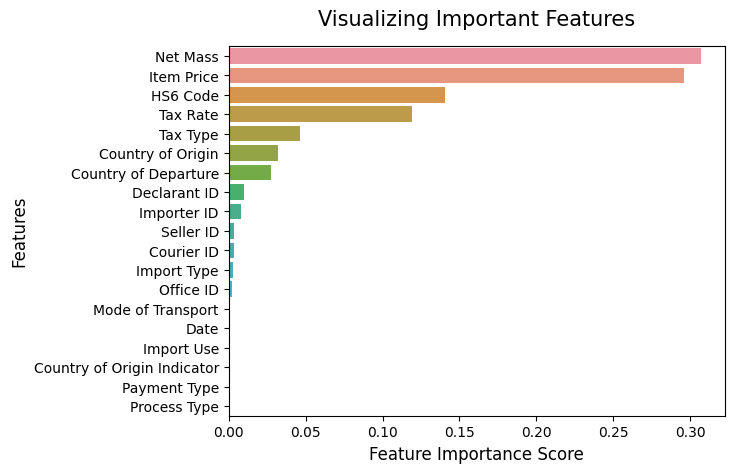

In [ ]:
#using random forest classifier to get the important score of features
rf = RandomForestClassifier(n_estimators=100, max_depth=3,
                                 bootstrap=True, n_jobs=-1,
                                 random_state=0)
rf.fit(x_train, y_train)

feature_imp = pd.Series(rf.feature_importances_,
                        index= X.columns).sort_values(ascending=False)
#plot feature importance score
print('Feature importances: ', rf.feature_importances_)
print(sns.barplot(x=feature_imp, y=feature_imp.index))
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Important Features", fontsize=15, pad=15)

From here, we can see that the features: Net Mass, Item Price, HS6 code, Tax Rate, Tax Type, Country of Origin and Country of Departure have significant importance. We will use the first 5 features to train the model.


Ploting the 3 most important features to have a more specific view of the data.

In [ ]:
import plotly
import plotly.offline as py
# py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np

#because the data set is large then I decided just capture a portion of it
train_true = train_df[(train_df['Fraud'] == 0) & (train_df['Item Price'] < 5) & (train_df['Net Mass'] < 5)][['Item Price', 'Net Mass', 'HS6 Code']]
train_fake = train_df[(train_df['Fraud'] == 1) & (train_df['Item Price'] < 5) & (train_df['Net Mass'] < 5)][['Item Price', 'Net Mass','HS6 Code']]
acid = go.Scatter3d(
    x = train_true['Item Price'],
    y = train_true['Net Mass'],
    z = train_true['HS6 Code'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(255,0,0)',
                  line=dict(width=0)),
    name ='true'
)
base = go.Scatter3d(
    x = train_fake['Item Price'],
    y = train_fake['Net Mass'],
    z = train_fake['HS6 Code'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(0,0,255)',
                  line=dict(width=0)),
    name ='Fraud'
)

data = [acid, base]
layout = go.Layout(
    title='Fraud',
    scene = dict(
        xaxis = dict(title='Item Price'),
        yaxis = dict(title='Net Mass'),
        zaxis = dict(title='HS6 Code'),)
)

py.iplot(go.Figure(data=data, layout=layout),filename='ph-scale')
del train_true, train_fake, acid, base, data

When looking at the figure, we can see that for a certain item, Net Mass and Item Price have a certain correlation.

## **5.a. KNeighborsClassifier**
In this project, I will introduce a new machine learning model called KNeighborsClassifier.

The working principle of KNeighborsClassifier is to determine the predicted label for a new data point based on the labels of the K nearest data points in the training set. In the accompanying figure, if we choose k=1, we will classify the new example into class 1, but with k=3, the label of the new example will be class 2. <br>
![picture](https://drive.google.com/uc?id=1ca5kOOdxxgHanFt_4Eoyiw6sntj7qFOA)
<br>
The distance will be calculated using the Euclidean distance. <br>
d(A,B) = $\sqrt{\sum_{i=1}^{n} \left({A_i - B_i}\right)^2}$
<br>
There are two options to consider when evaluating the importance of the distances between points[2].

Option 1: uniform weights, where all points in each neighborhood are weighted equally.

Option 2: weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors that are further away.

In this model, I want closer points to have a greater influence, so I will choose to weight points by the inverse of their distance.

```
#input: list of distance
def _inverse_distance_weighting(distances):
    distances = np.where(distances == 0, np.finfo(float).eps, distances)
    weights = 1 / distances
    return weights
assert _inverse_distance_weighting([2])[0] == 0.5
```



For a new given point being considered and a list of distances from the new point to the points in the training data, we select the k nearest points based on their distances and retrieve the labels of those k points. The bincount() function is used to evaluate the vote of label '0' and label '1' by summing all the weights of the k selected points grouped by their labels.

```
k_nearest_labels = [1,1,1,0,0]
weights = [0.25, 0.8, 0.9, 0.001, 0.02]
print(np.bincount(k_nearest_labels, weights=weights))
#output
[0.021 1.95 ]
```



For each new point x, the label with the higher vote will become the label for x.


```
distances = cdist(X_train, [x])
indices = np.argsort(distances.flatten())[:k]
k_nearest_labels = y_train[indices].flatten()
weights = _inverse_distance_weighting(distances[indices])
weighted_votes = np.bincount(k_nearest_labels, weights=weights.flatten())
pred_label = np.argmax(weighted_votes)
y_pred.append(pred_label)
```



Use the accuracy_score function to evaluate the accuracy of the model

```
def accuracy_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)
```



### Running model:

In [ ]:
import timeit

start = timeit.default_timer()
cols = ['Net Mass', 'Item Price', 'HS6 Code', 'Tax Rate', 'Tax Type']
X_train = x_train[cols]
X_test = x_test[cols]
y_train = train_df['Fraud']


class KNeighborsClassifier:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X_train, y_train):
        self.X_train = X_train.values
        self.y_train = y_train.values

    def _inverse_distance_weighting(self, distances):
        distances = np.where(distances == 0, np.finfo(float).eps, distances)
        weights = 1 / distances
        # weights = distances
        return weights

    def predict(self, X_test):
        X_test = X_test.values
        y_pred = []
        for x in X_test:
            distances = cdist(self.X_train, [x])
            indices = np.argsort(distances.flatten())[:self.n_neighbors]
            k_nearest_labels = self.y_train[indices].flatten()
            weights = self._inverse_distance_weighting(distances[indices])
            weighted_votes = np.bincount(k_nearest_labels, weights=weights.flatten())
            pred_label = np.argmax(weighted_votes)
            y_pred.append(pred_label)
        return np.array(y_pred)

    def accuracy_score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return accuracy_score(y_test, y_pred)

# k = 300 #let begin with k equals to 300
for k in range (100, 300, 50):
  knn_classifier = KNeighborsClassifier(n_neighbors=k)
  knn_classifier.fit(X_train, y_train)

  pct_correct= knn_classifier.accuracy_score(X_test, y_test)
  print("knn "+ str(k) + ": "+ str(pct_correct))

stop = timeit.default_timer()
print('Running time: ', stop - start)

knn 100: 0.9327909444640962
knn 150: 0.9329088550878434
knn 200: 0.9329088550878434
knn 250: 0.9329088550878434
Running time:  222.05577354900015


With the same for loop of k, compare the knn_inverse_distance_weighted with the build-in KNeighborsClassifier from sklearn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

start = timeit.default_timer()
arr_y_train = y_train.to_numpy()
for k in range(100, 300, 50):
  neigh= KNeighborsClassifier(n_neighbors= k,weights= 'distance');
  neigh.fit(X_train, arr_y_train);
  predicted= neigh.predict(X_test);
  pct_correct= accuracy_score(y_test, predicted);
  print("knn "+ str(k) + ": "+ str(pct_correct))
stop = timeit.default_timer()
print('Running time: ', stop - start)

knn 100: 0.932673033840349
knn 150: 0.9327909444640962
knn 200: 0.9327909444640962
knn 250: 0.9327909444640962
Running time:  1.6903834300028393


## **5.b. Neural Network model**
To evaluate the accuracy and optimization of KNeighborsClassifier, I use the Neural network model to measure the accuracy of the KNeighborsClassifier model that I will introduce below.<br>
Neural Network model: <br>


*   Layer: 2 hidden layer with 128, 30 units respectively.
*   Activation function: softmax function for hidden layer and sigmoid function for output layer
* epoches = 20, batch_size = 5000




7
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 30)                3870      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 4,925
Trainable params: 4,925
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
8/8 [==============================] - 1s 48ms/step - loss: 0.6716 - accuracy: 0.7830 - val_loss: 0.6680 - val_accuracy: 0.7905
Epoch 2/20
8/8 [==============================] - 0s 19ms/step - loss: 0.6666 - accuracy: 0.7830 - val_loss: 0.6628 - val_accuracy: 0.7905
Epoch 3/20
8/8 [======================

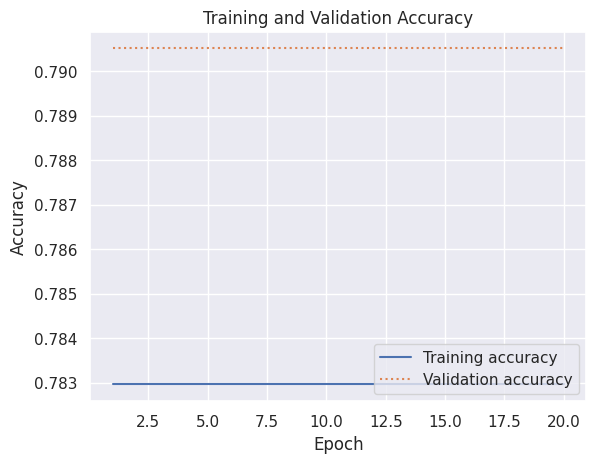

In [ ]:
def NeuralNetwork(x_train, x_valid, x_test):
  cols = ['Net Mass', 'Item Price', 'HS6 Code', 'Tax Rate', 'Tax Type', 'Country of Origin', 'Country of Departure']
  x_nn_train = x_train[cols]
  x_nn_valid = x_valid[cols]
  x_nn_test = x_test[cols]
  input_dim = len(x_nn_train.columns)
  print(input_dim)
  model = Sequential()
  model.add(Dense(128, activation='softmax', input_dim= input_dim))
  model.add(Dense(30, activation='softmax'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()

  hist = model.fit(x_nn_train, y_train, validation_data=(x_nn_valid, y_valid), epochs= 20, batch_size=5000)
  y_predicted = model.predict(x_nn_test) > 0.5
  import matplotlib.pyplot as plt
  %matplotlib inline
  import seaborn as sns
  sns.set()
  acc = hist.history['accuracy']
  val = hist.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, '-', label='Training accuracy')
  plt.plot(epochs, val, ':', label='Validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.plot()
  mat = confusion_matrix(y_test, y_predicted)
  return mat
confusion_mat = NeuralNetwork(x_train, x_valid, x_test)

Portion of fraud declaration in train dataset: 0.21703891935268155
Portion of not fraud declaration in train dataset: 0.7829610806473184


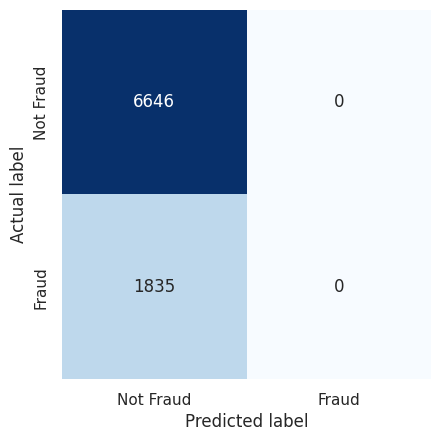

In [ ]:
print("Portion of fraud declaration in train dataset: " + str(y_train.value_counts()[1] / len(y_train)))
print("Portion of not fraud declaration in train dataset: " + str(y_train.value_counts()[0] / len(y_train)))


labels = ['Not Fraud', 'Fraud']

sns.heatmap(confusion_mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
del labels, confusion_mat

We can see that the neural network does not work well with this dataset. All predicted values are 1. This is understandable since in train data there are many times more data labeled as 1 than data labeled as 0.

## **6. Result compare and conclusion**

In the test case, KNN shows higher accuracy than Neural Network. Compared to the built-in library, the self-build function shows 93.3% of accurary while Neural Network only produces 79.05% of accuracy. 93.3% of accurary is a pretty high number and proves that KNeighborsClassifier (KNC) is the suitable algorithm for this dataset.

Additionally, when running the built-in KNC function of scikit learn, we can see the same prediction accuracy with 93.3% of accuracy for both model with different K (100, 150, 200, 250). However, in term of running time, the built-in KNC function also has the much better performance compare to the self-built KNC function. The built-in KNC function only takes 3.277s to run model with 4 different values of K while the self-built KNC function takes 237.57s to run which is 72 times slower.


Another weakness of the self-build knn in this project is still not optimal. In case k runs from a certain interval, it will fail because of maximum recursion depth exceeded. Whereas knn built-in works well with having many k values.


In the future, for this dataset, it is possible to use ensemble learning and use more data science knowledge to be able to manipulate the dataset better to get more accurate results.

Reference:
1. Chaeyoon Jeong, Sundong Kim, Jaewoo Park, Yeonsoo Choi, 2022. Customs Import Declaration Datasets. https://arxiv.org/abs/2208.02484
2. KNeighborsClassifier. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
3. Classification Tree. https://www.math.snu.ac.kr/~hichoi/machinelearning/lecturenotes/CART.pdf?fbclid=IwAR3vbss6AXbTFCm9VY-ndzL-t4SUsPHkU_o6bTs6QktwtkeFUa5k-NVDaCU